# Human Activity Recognition
### Mini-Project Chunlei Zhou

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA

## Exploratory Analysis 
Analyze some core features only. Mean values are picked for exploration.

In [2]:
# Correlation Analysis using Heatmap
def correlation_heatmap(dataset, width = None, length = None):
    '''
    This function will plot a heatmap for the input dataset to show correlation between different x_features and y
    Input: a dataset with x_features and y(last column)
    Output: a correlation heatmap
    '''
    if width and length:
        fig,ax = plt.subplots(figsize = (width, length))
    else:
        fig,ax = plt.subplots()
    ax = sns.heatmap(dataset.corr(),vmin = -1, vmax = 1, square = True, cmap = sns.diverging_palette(240, 10, as_cmap=True))
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    return ax

In [3]:
# Load Data
HAR = pd.read_csv('DataSet_HAR.csv')

# Overview of Data
print(HAR.shape)
print(HAR.head)
print(HAR.Activity.value_counts())

# Pick core features only
core_features = ['tBodyAcc-mean()-X','tBodyAcc-mean()-Y','tBodyAcc-mean()-Z',
                'tGravityAcc-mean()-X','tGravityAcc-mean()-Y','tGravityAcc-mean()-Z',
                'tBodyAccJerk-mean()-X','tBodyAccJerk-mean()-Y','tBodyAccJerk-mean()-Z',
                'tBodyGyro-mean()-X','tBodyGyro-mean()-Y','tBodyGyro-mean()-Z',
                'tBodyGyroJerk-mean()-X','tBodyGyroJerk-mean()-Y','tBodyGyroJerk-mean()-Z',
                'tBodyAccMag-mean()',
                'tGravityAccMag-mean()',
                'tBodyAccJerkMag-mean()',
                'tBodyGyroMag-mean()',
                'tBodyGyroJerkMag-mean()']

(10299, 563)
<bound method NDFrame.head of        tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
0               0.288585          -0.020294          -0.132905   
1               0.278419          -0.016411          -0.123520   
2               0.279653          -0.019467          -0.113462   
3               0.279174          -0.026201          -0.123283   
4               0.276629          -0.016570          -0.115362   
...                  ...                ...                ...   
10294           0.310155          -0.053391          -0.099109   
10295           0.363385          -0.039214          -0.105915   
10296           0.349966           0.030077          -0.115788   
10297           0.237594           0.018467          -0.096499   
10298           0.153627          -0.018437          -0.137018   

       tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
0             -0.995279         -0.983111         -0.913526         -0.995112   
1 

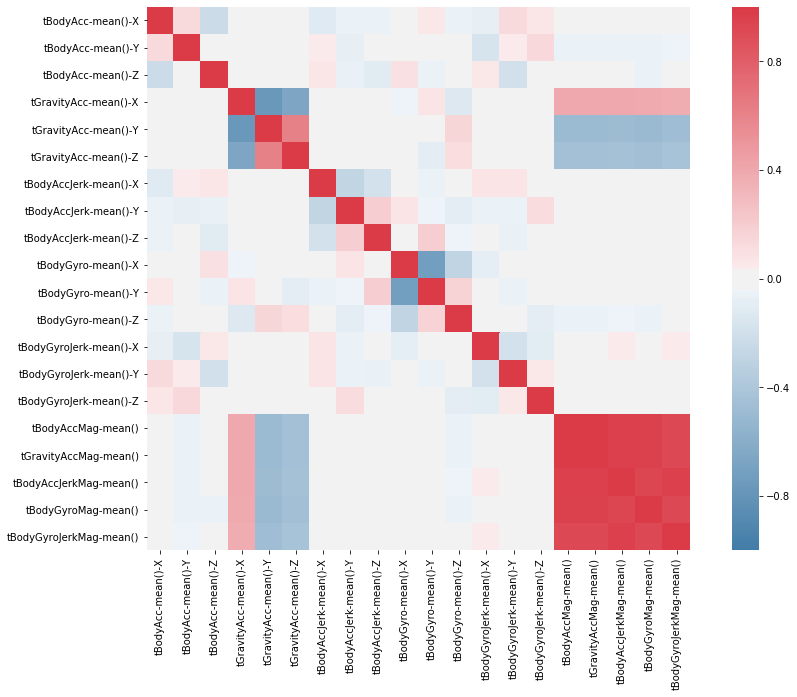

In [4]:
correlation_heatmap(HAR.filter(items = core_features), width = 15, length = 10)

## Train-Test Split
Split the whole dataset to training dataset and testing dataset roughly based on 8:2. 

In [5]:
# How large is 80% of the whole dataset?
round(HAR.shape[0]*0.8)

8239

In [6]:
HAR.subject.value_counts().cumsum()

25      409
21      817
26     1209
30     1592
28     1974
24     2355
27     2731
23     3103
17     3471
16     3837
18     4201
19     4561
20     4915
1      5262
29     5606
3      5947
15     6275
13     6602
6      6927
14     7250
22     7571
12     7891
4      8208
11     8524
7      8832
2      9134
5      9436
10     9730
9     10018
8     10299
Name: subject, dtype: int64

**Note**: Based on the above analysis, we can leave subjects `11`, `7`, `2`, `5`, `10`, `9`, `8` in the testing file. The 7 listed subjects consist of 20% of the entire dataset approximately. 

In [7]:
test_subjects = [11,7,2,5,10,9,8]
# Training set
train = HAR.loc[~HAR.subject.isin(test_subjects),:]
train.drop(columns = 'subject', inplace = True)
train_x = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
# Testing set
test = HAR.loc[HAR.subject.isin(test_subjects),:]
test.drop(columns = 'subject', inplace = True)
test_x = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Objective 1: Build Two Predictive Models 

### Model 1: Logistic Regression 

In [8]:
# Train a logistic regression model
LR = LogisticRegression(solver = 'newton-cg', multi_class = 'multinomial')
LR_fitted = LR.fit(train_x,train_y)
# Prediction using logistic regression model
LR_prediction = LR_fitted.predict(test_x)

### Model 2: Multi-Layer Perceptron Classifier 

In [13]:
# Train a MLP Classifier
MLP = MLPClassifier(hidden_layer_sizes=(830, ),max_iter=1000,solver='lbfgs')
MLP_fitted = MLP.fit(train_x,train_y)
# Prediction using MLP Classifier
MLP_prediction = MLP_fitted.predict(test_x)

### Comparison of Model Performances 

def plot_confusion_matrix(df_confusion, title='Confusion Matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=plt.cm.Blues) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    bottom, top = plt.get_ylim()
    plt.set_ylim(bottom + 0.5, top - 0.5)

In [9]:
# Plot the Confusion Matrix
def plot_confusion_matrix_improved(y_pred, y_true, width=None, length=None, title=None, normalize = False, cmap = None):
    '''
    This function visualizes the confusion matrix.
    Input: 
        y_pred: prediction of y;
        y_ture: truth
        width, length: figure size
        title: figure title
        normalize: normalize confusion matrix if normalize = True
        cmap: plot the given color map (map continue values to colors)
    Output: the visualized confusion matrix
    '''
    if width and length:
        fig, ax = plt.subplots(figsize = (width, length),constrained_layout=True)
    else:
        fig, ax = plt.subplots(constrained_layout=True)
    # Default title
    if not title:
        if normalize:
            title = 'Normalized Confusion Matrix'
        else:
            title = 'Confusion Matrix (Not Normalized)'
    # Default color (Red)
    if not cmap:
        cmap = plt.cm.Reds
    # Compute Confusion Matrix
    cm = confusion_matrix(y_true,y_pred)
    # Class Labels
    labels = unique_labels(y_pred, y_true)
    # Normalization
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)
        fmt = '.2f'
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix without Normalization')
        fmt = 'd'
    im = ax.matshow(cm, cmap = cmap)
    ax.figure.colorbar(im)
    # Show all ticks and label them
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='Actual', xlabel='Prediction')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.xaxis.tick_bottom()
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=45)
    ax.grid(False)
    ax.title.set_fontsize(16)
    ax.xaxis.label.set_fontsize(14) 
    ax.yaxis.label.set_fontsize(14)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return ax

In [14]:
print('''
Accuracy: 
- Logistic Regression: {:.2f}%
- MLP Classifier: {:.2f}%
'''.format(100*accuracy_score(test_y, LR_prediction), 
           100*accuracy_score(test_y, MLP_prediction)))


Accuracy: 
- Logistic Regression: 93.64%
- MLP Classifier: 94.31%



In [10]:
print(classification_report(test_y, LR_prediction, 
                            target_names = ['LAYING','SITTING','STANDING',
                                            'WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       371
           SITTING       0.88      0.89      0.88       341
          STANDING       0.90      0.88      0.89       353
           WALKING       0.90      0.99      0.94       384
WALKING_DOWNSTAIRS       0.98      0.98      0.98       305
  WALKING_UPSTAIRS       0.97      0.88      0.93       337

          accuracy                           0.94      2091
         macro avg       0.94      0.94      0.94      2091
      weighted avg       0.94      0.94      0.94      2091



In [16]:
print(classification_report(test_y, MLP_prediction, 
                            target_names = ['LAYING','SITTING','STANDING',
                                            'WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       371
           SITTING       0.90      0.91      0.91       341
          STANDING       0.92      0.90      0.91       353
           WALKING       0.92      0.96      0.94       384
WALKING_DOWNSTAIRS       0.94      0.99      0.97       305
  WALKING_UPSTAIRS       0.98      0.90      0.94       337

          accuracy                           0.94      2091
         macro avg       0.94      0.94      0.94      2091
      weighted avg       0.94      0.94      0.94      2091



In [17]:
y_actu = pd.Series(test_y, name='Actual')
y_pred_LR = pd.Series(LR_prediction, name='Predicted')
y_pred_MLP = pd.Series(MLP_prediction, name='Predicted')
df_confusion_LR = pd.crosstab(y_actu, y_pred_LR, rownames=['Actual'], colnames=['Predicted'])#, margins=True)
df_confusion_MLP = pd.crosstab(y_actu, y_pred_MLP, rownames=['Actual'], colnames=['Predicted'])#, margins=True)
df_confusion_LR

Predicted,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
Actual,,,,,,
LAYING,1,65,113,0,0,9
SITTING,0,8,51,15,13,84
STANDING,0,0,0,45,112,53
WALKING,95,83,12,0,0,0
WALKING_DOWNSTAIRS,89,3,0,62,0,0
WALKING_UPSTAIRS,7,0,0,113,36,9


In [18]:
df_confusion_MLP

Predicted,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
Actual,,,,,,
LAYING,1,81,100,1,0,5
SITTING,0,4,56,10,13,88
STANDING,0,0,0,33,115,62
WALKING,95,81,14,0,0,0
WALKING_DOWNSTAIRS,89,3,0,62,0,0
WALKING_UPSTAIRS,7,0,0,110,39,9


In [19]:
df_conf_norm_LR = df_confusion_LR / df_confusion_LR.sum(axis=1)
df_conf_norm_LR

Predicted,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
Actual,,,,,,
LAYING,0.005319,0.380117,0.538095,0.000000,0.000000,0.054545
SITTING,0.000000,0.046784,0.242857,0.078947,0.084416,0.509091
STANDING,0.000000,0.000000,0.000000,0.236842,0.727273,0.321212
WALKING,0.505319,0.485380,0.057143,0.000000,0.000000,0.000000
WALKING_DOWNSTAIRS,0.473404,0.017544,0.000000,0.326316,0.000000,0.000000
WALKING_UPSTAIRS,0.037234,0.000000,0.000000,0.594737,0.233766,0.054545


In [20]:
df_conf_norm_MLP = df_confusion_MLP / df_confusion_MLP.sum(axis=1)
df_conf_norm_MLP

Predicted,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
Actual,,,,,,
LAYING,0.005319,0.473684,0.476190,0.005263,0.000000,0.030303
SITTING,0.000000,0.023392,0.266667,0.052632,0.084416,0.533333
STANDING,0.000000,0.000000,0.000000,0.173684,0.746753,0.375758
WALKING,0.505319,0.473684,0.066667,0.000000,0.000000,0.000000
WALKING_DOWNSTAIRS,0.473404,0.017544,0.000000,0.326316,0.000000,0.000000
WALKING_UPSTAIRS,0.037234,0.000000,0.000000,0.578947,0.253247,0.054545


Confusion Matrix without Normalization


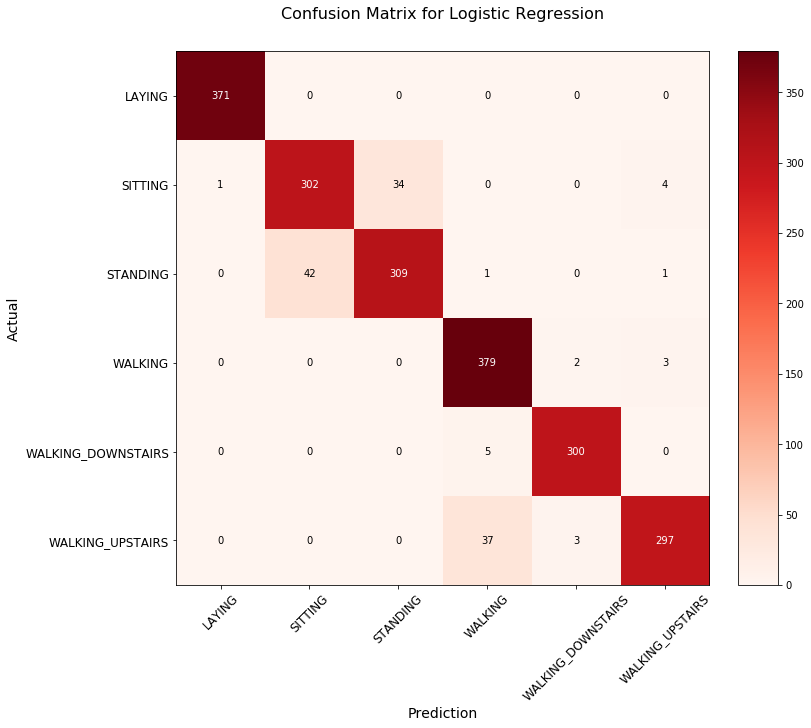

In [11]:
plot_confusion_matrix_improved(LR_prediction, test_y, width=15, length=10,
                               title='Confusion Matrix for Logistic Regression')

Confusion Matrix without Normalization


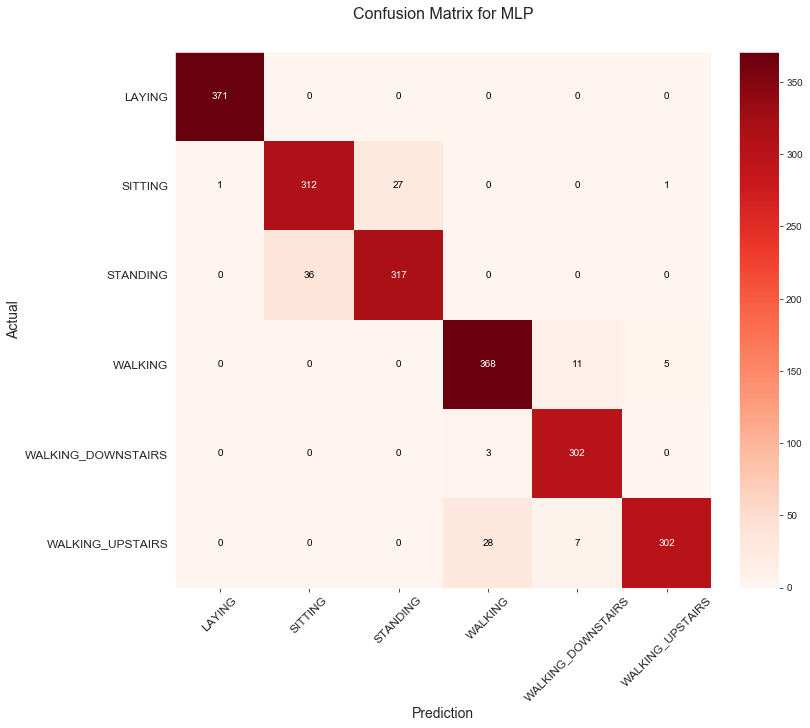

In [167]:
plot_confusion_matrix_improved(MLP_prediction, test_y, width=15, length=10, 
                               title='Confusion Matrix for MLP')

## Objective 2: Select Features 

In [24]:
feature_importance = abs(LR_fitted.coef_[0])
feature_importance_pct = 100.0 * (feature_importance / feature_importance.max())
ranked_index = np.argsort(feature_importance_pct)

array([492, 475, 307, 498, 322, 241, 493, 107, 246, 480, 343, 376, 333,
       478, 484, 501, 479, 544, 265, 485, 487, 491, 240, 476, 477, 526,
       388, 170, 483, 312, 334, 377, 138, 481, 547, 316, 177, 412,  29,
       327, 271, 413, 379, 422, 557, 416, 306, 402, 339, 415,  78, 494,
       530, 463, 420, 137, 419, 242, 160, 528, 533, 275, 529, 542, 340,
       418, 108, 467, 435, 380, 387, 473, 258, 315, 471, 154, 392, 372,
       490, 332, 466, 305, 414, 499, 525, 497, 105, 161, 489, 464, 411,
       144, 117,  10, 465, 331, 133, 470, 244, 239, 273,  98, 362, 320,
       443, 406, 323, 173, 385, 321, 178, 319, 495, 289, 462, 469, 401,
       303, 326, 329, 399, 267,  17, 384, 391, 398, 440, 176, 308, 304,
       335, 311, 386, 537, 482, 280, 486, 545, 186, 410, 543, 408,   1,
       421, 324, 383, 253, 255, 382, 211, 224, 245, 131, 374, 136, 164,
       448, 328, 318, 531, 282, 534, 313, 424, 488, 254, 390, 394, 405,
       549, 358, 389, 381, 461, 496, 325, 535, 113,  96, 360, 52

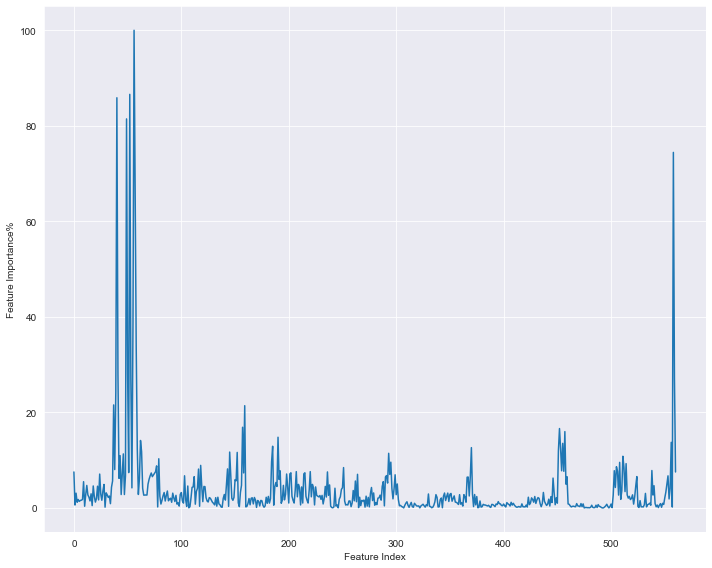

In [34]:
sns.set_style("darkgrid")
feature_index = np.arange(len(feature_importance_pct))
fig = plt.figure(figsize=(10,8))
#plt.scatter(feature_importance_pct,feature_index)
plt.plot(feature_importance_pct)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance%')
plt.tight_layout()  
plt.show()
sorted_idx = np.argsort(feature_importance_pct)

In [16]:
feature_f_score,feature_p_value = f_classif(train_x,train_y)
ranked_index_f = np.argsort(-feature_f_score)
ranked_index_p = np.argsort(feature_p_value)

In [17]:
ranked_index_f

array([366,  40,  52,  56,  49, 367, 234, 287, 102, 523, 104, 368, 558,
         9, 103, 280,   3, 288, 271,  15, 268, 510, 218, 200, 213, 205,
         6, 289, 265, 184, 216, 203, 226, 231,  95, 359, 504, 272, 228,
       266, 502, 507, 233, 549, 227,   4,  83,  87,  86, 447, 515, 520,
       344, 350, 201, 214, 347, 345,  84, 516,   7, 517, 274, 269, 351,
       445, 348, 260, 100, 509, 135, 244, 239, 182, 215, 202, 446,  99,
        12, 503, 536, 229, 522,  19, 363, 438, 285, 364, 518, 284, 425,
       221, 208, 353, 183,  20,  89, 431, 354,  13,  10,  92, 423, 125,
       168, 429, 273, 267, 128, 181, 166, 165,  93, 179,   8,   5, 163,
       175,  50, 428,  41, 126, 123,  90, 444, 220, 207, 346,  53,  88,
       219, 206, 257, 252,  85, 275, 270, 352, 139,  21, 559, 141, 286,
       171, 426, 349, 101, 241, 533, 528, 365, 314, 281, 505, 246, 442,
        16, 508, 310, 134, 242, 530, 240, 302,  22,  23, 131,  11, 169,
        94, 259, 535, 127, 172,  14, 424, 140, 529, 124, 434, 43

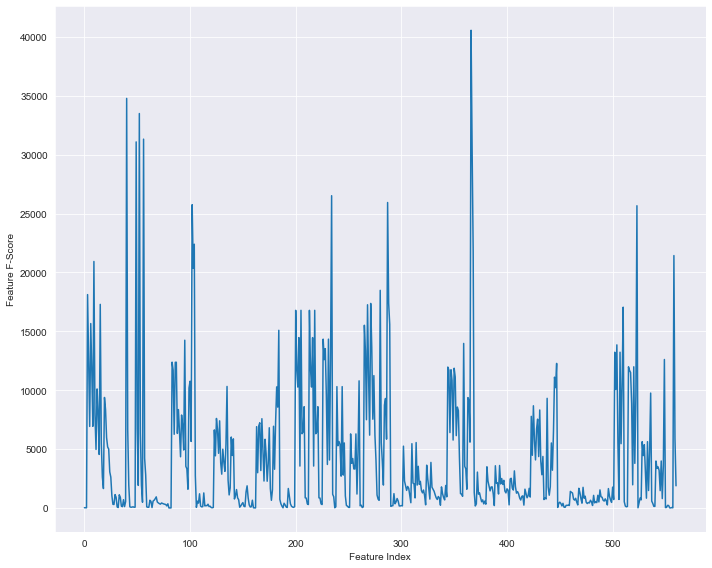

In [18]:
sns.set_style("darkgrid")
feature_index = np.arange(len(ranked_index_f))
fig = plt.figure(figsize=(10,8))
plt.plot(feature_f_score)
plt.xlabel('Feature Index')
plt.ylabel('Feature F-Score')
plt.tight_layout()  
plt.show()

In [63]:
ranked_index_p

array([280, 366, 365, 364, 363, 362, 361, 360, 359, 358, 357, 356, 355,
       354, 367, 353, 351, 350, 349, 348, 347, 346, 345, 344, 343, 342,
       341, 340, 339, 352, 338, 368, 371, 401, 400, 399, 398, 397, 396,
       395, 394, 393, 392, 391, 390, 389, 369, 387, 385, 384, 383, 382,
       381, 379, 378, 377, 376, 375, 374, 373, 372, 386, 336, 335, 334,
       295, 294, 293, 289, 288, 287, 286, 285, 284, 283, 282, 281, 559,
       296, 279, 277, 276, 275, 274, 273, 272, 271, 270, 269, 268, 267,
       266, 265, 278, 297, 302, 303, 333, 332, 331, 330, 329, 328, 327,
       326, 325, 324, 322, 321, 320, 319, 318, 317, 316, 315, 314, 313,
       312, 311, 310, 309, 308, 307, 306, 305, 304, 403, 404, 405, 406,
       511, 510, 509, 508, 507, 506, 505, 504, 503, 502, 501, 500, 499,
       515, 498, 496, 494, 493, 492, 491, 490, 489, 488, 487, 486, 485,
       484, 483, 497, 516, 517, 518, 558, 549, 548, 547, 546, 545, 544,
       543, 542, 541, 538, 537, 536, 535, 534, 533, 532, 531, 53

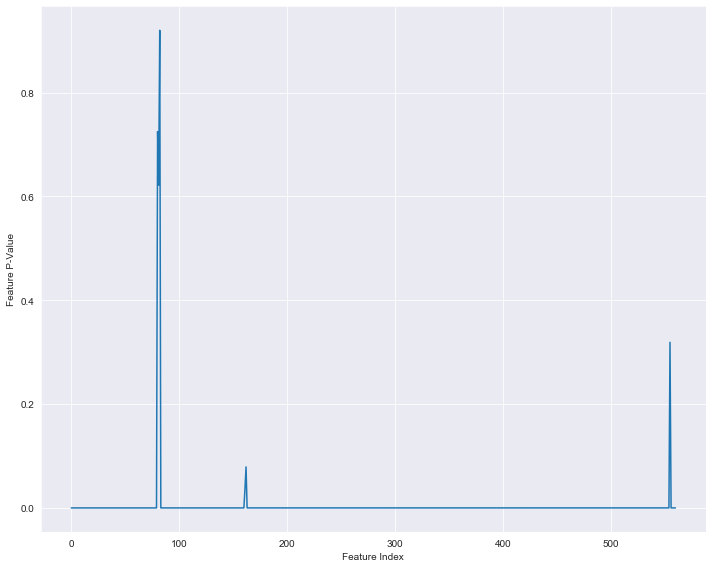

In [66]:
sns.set_style("darkgrid")
feature_index = np.arange(len(ranked_index_p))
fig = plt.figure(figsize=(10,8))
plt.plot(feature_p_value)
plt.xlabel('Feature Index')
plt.ylabel('Feature P-Value')
plt.tight_layout()  
plt.show()

In [19]:
accuracy_dict={}
LR_reduced_feature = LogisticRegression(solver = 'newton-cg', multi_class = 'multinomial')
for n in range(len(ranked_index_f)):
    features_selected = ranked_index_f[:n+1]
    LR_reduced_feature = LR_reduced_feature.fit(train_x.iloc[:,features_selected],train_y)
    LR_pred = LR_reduced_feature.predict(test_x.iloc[:,features_selected])
    accuracy = 100*accuracy_score(test_y, LR_pred)
    accuracy_dict[n+1]=accuracy
    print('Selected',len(features_selected),'features... Accuracy: {:.2f}%'
          .format(accuracy))
    if accuracy >= 90:
        break
print("Features Selection Finished!")

Selected 1 features... Accuracy: 47.39%
Selected 2 features... Accuracy: 72.74%
Selected 3 features... Accuracy: 73.79%
Selected 4 features... Accuracy: 73.41%
Selected 5 features... Accuracy: 74.03%
Selected 6 features... Accuracy: 76.37%
Selected 7 features... Accuracy: 77.76%
Selected 8 features... Accuracy: 78.19%
Selected 9 features... Accuracy: 78.24%
Selected 10 features... Accuracy: 78.05%
Selected 11 features... Accuracy: 79.77%
Selected 12 features... Accuracy: 79.15%
Selected 13 features... Accuracy: 82.50%
Selected 14 features... Accuracy: 86.04%
Selected 15 features... Accuracy: 84.60%
Selected 16 features... Accuracy: 85.94%
Selected 17 features... Accuracy: 86.13%
Selected 18 features... Accuracy: 86.32%
Selected 19 features... Accuracy: 86.37%
Selected 20 features... Accuracy: 86.80%
Selected 21 features... Accuracy: 86.27%
Selected 22 features... Accuracy: 86.42%
Selected 23 features... Accuracy: 86.47%
Selected 24 features... Accuracy: 86.56%
Selected 25 features... A

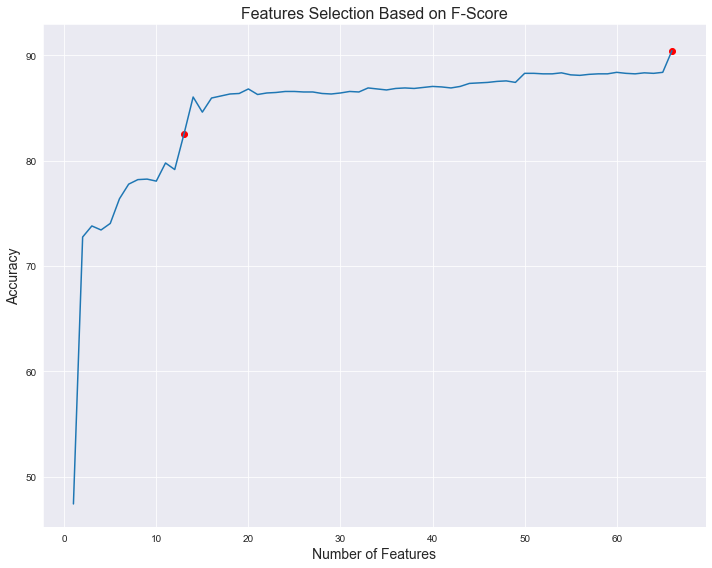

In [21]:
df = pd.DataFrame(list(accuracy_dict.items()), columns =['Number of Features', 'Accuracy']) 
sns.set_style("darkgrid")
fig = plt.figure(figsize=(10,8))
#df.plot(x ='Number of Features', y='Accuracy', kind = 'line')
sns.lineplot(df.loc[:,'Number of Features'],df.loc[:,'Accuracy'])
plt.xlabel('Number of Features', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.title('Features Selection Based on F-Score', fontsize = 16)
plt.scatter(df.loc[:,'Number of Features'][65], df.loc[:,'Accuracy'][65], c = 'r')
plt.scatter(df.loc[:,'Number of Features'][12], df.loc[:,'Accuracy'][12], c = 'r')
fig.tight_layout()  
plt.show()

In [191]:
accuracy_dict_p={}
LR_reduced_feature_p = LogisticRegression(solver = 'newton-cg', multi_class = 'multinomial')
for n in range(len(ranked_index_p)):
    features_selected_p = ranked_index_p[:n+1]
    LR_reduced_feature_p = LR_reduced_feature_p.fit(train_x.iloc[:,features_selected_p],train_y)
    LR_pred_p = LR_reduced_feature_p.predict(test_x.iloc[:,features_selected_p])
    accuracy_p = 100*accuracy_score(test_y, LR_pred_p)
    accuracy_dict_p[n+1]=accuracy_p
    print('Selected',len(features_selected_p),'features... Accuracy: {:.2f}%'
          .format(accuracy_p))
    if accuracy_p >= 90:
        break
print("Features Selection Finished!")

Selected 1 features... Accuracy: 44.24%
Selected 2 features... Accuracy: 45.43%
Selected 3 features... Accuracy: 47.39%
Selected 4 features... Accuracy: 52.75%
Selected 5 features... Accuracy: 52.08%
Selected 6 features... Accuracy: 53.95%
Selected 7 features... Accuracy: 57.44%
Selected 8 features... Accuracy: 58.25%
Selected 9 features... Accuracy: 58.58%
Selected 10 features... Accuracy: 58.87%
Selected 11 features... Accuracy: 59.30%
Selected 12 features... Accuracy: 59.25%
Selected 13 features... Accuracy: 58.92%
Selected 14 features... Accuracy: 59.59%
Selected 15 features... Accuracy: 61.02%
Selected 16 features... Accuracy: 61.07%
Selected 17 features... Accuracy: 61.07%
Selected 18 features... Accuracy: 61.26%
Selected 19 features... Accuracy: 61.26%
Selected 20 features... Accuracy: 61.17%
Selected 21 features... Accuracy: 61.21%
Selected 22 features... Accuracy: 61.41%
Selected 23 features... Accuracy: 61.50%
Selected 24 features... Accuracy: 61.79%
Selected 25 features... A

Selected 199 features... Accuracy: 86.47%
Selected 200 features... Accuracy: 86.23%
Selected 201 features... Accuracy: 86.23%
Selected 202 features... Accuracy: 86.51%
Selected 203 features... Accuracy: 86.51%
Selected 204 features... Accuracy: 86.51%
Selected 205 features... Accuracy: 86.61%
Selected 206 features... Accuracy: 86.61%
Selected 207 features... Accuracy: 86.61%
Selected 208 features... Accuracy: 86.66%
Selected 209 features... Accuracy: 86.61%
Selected 210 features... Accuracy: 86.61%
Selected 211 features... Accuracy: 86.61%
Selected 212 features... Accuracy: 86.61%
Selected 213 features... Accuracy: 86.61%
Selected 214 features... Accuracy: 86.61%
Selected 215 features... Accuracy: 86.61%
Selected 216 features... Accuracy: 86.61%
Selected 217 features... Accuracy: 86.61%
Selected 218 features... Accuracy: 86.61%
Selected 219 features... Accuracy: 86.61%
Selected 220 features... Accuracy: 86.66%
Selected 221 features... Accuracy: 86.70%
Selected 222 features... Accuracy:

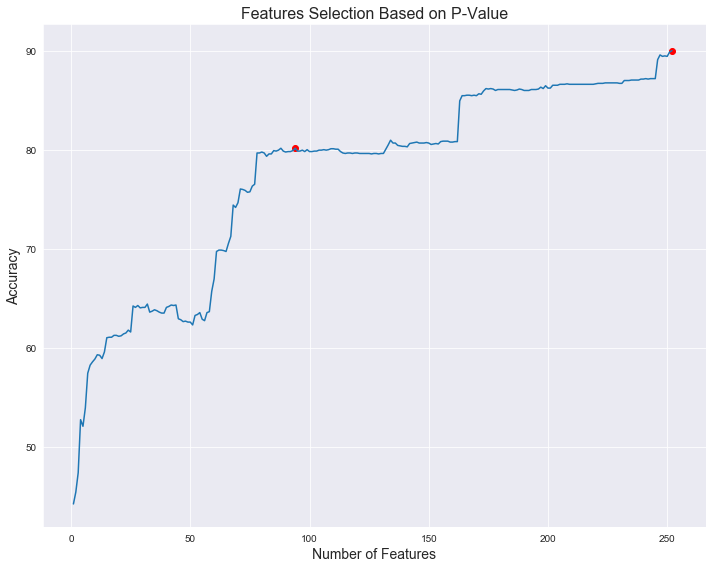

In [214]:
df = pd.DataFrame(list(accuracy_dict_p.items()), columns =['Number of Features', 'Accuracy']) 
sns.set_style("darkgrid")
fig = plt.figure(figsize=(10,8))
#df.plot(x ='Number of Features', y='Accuracy', kind = 'line')
sns.lineplot(df.loc[:,'Number of Features'],df.loc[:,'Accuracy'])
plt.xlabel('Number of Features', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.title('Features Selection Based on P-Value',fontsize = 16)
plt.scatter(df.loc[:,'Number of Features'][251], df.loc[:,'Accuracy'][251], c = 'r')
plt.scatter(df.loc[:,'Number of Features'][93], df.loc[:,'Accuracy'][93], c = 'r')
fig.tight_layout()  
plt.show()

## Objective 3: Apply Dimentionally Reduction 

In [192]:
accuracy_dict_pca = {} 
LR_pca = LogisticRegression(solver = 'newton-cg', multi_class = 'multinomial')
for d in range(1,561):
    pca = PCA(n_components = d)
    pca.fit(train_x)
    pca_train = pca.transform(train_x)
    pca_test = pca.transform(test_x)
    LR_pca = LR_pca.fit(pca_train,train_y)
    LR_pca_pred = LR_pca.predict(pca_test)
    accuracy_pca = 100*accuracy_score(test_y, LR_pca_pred)
    accuracy_dict_pca[d]=accuracy_pca
    print('Number of Dimensions:',d,'Accuracy: {:.2f}%'.format(accuracy_pca))
    if accuracy_pca >= 90:
        break
print("Dimentionally Reduction Finished!")

Number of Dimensions: 1 Accuracy: 47.20%
Number of Dimensions: 2 Accuracy: 64.18%
Number of Dimensions: 3 Accuracy: 77.76%
Number of Dimensions: 4 Accuracy: 79.53%
Number of Dimensions: 5 Accuracy: 82.21%
Number of Dimensions: 6 Accuracy: 82.35%
Number of Dimensions: 7 Accuracy: 84.22%
Number of Dimensions: 8 Accuracy: 84.46%
Number of Dimensions: 9 Accuracy: 85.80%
Number of Dimensions: 10 Accuracy: 86.90%
Number of Dimensions: 11 Accuracy: 87.47%
Number of Dimensions: 12 Accuracy: 87.80%
Number of Dimensions: 13 Accuracy: 86.66%
Number of Dimensions: 14 Accuracy: 87.71%
Number of Dimensions: 15 Accuracy: 87.04%
Number of Dimensions: 16 Accuracy: 87.42%
Number of Dimensions: 17 Accuracy: 87.57%
Number of Dimensions: 18 Accuracy: 87.71%
Number of Dimensions: 19 Accuracy: 88.00%
Number of Dimensions: 20 Accuracy: 88.19%
Number of Dimensions: 21 Accuracy: 88.86%
Number of Dimensions: 22 Accuracy: 88.33%
Number of Dimensions: 23 Accuracy: 88.71%
Number of Dimensions: 24 Accuracy: 89.14%
N

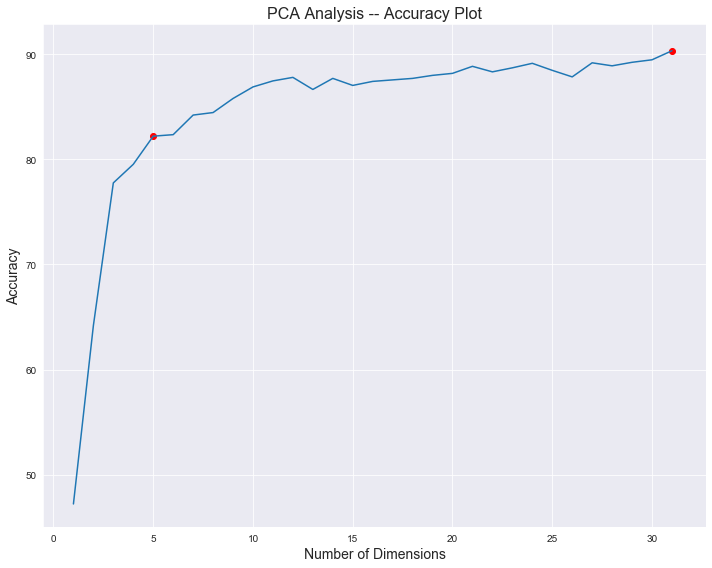

In [213]:
df = pd.DataFrame(list(accuracy_dict_pca.items()), columns =['Number of Dimensions', 'Accuracy'])
sns.set_style("darkgrid")
fig = plt.figure(figsize=(10,8))
sns.lineplot(df.loc[:,'Number of Dimensions'],df.loc[:,'Accuracy'])
plt.xlabel('Number of Dimensions',fontsize = 14)
plt.ylabel('Accuracy',fontsize = 14)
#df.plot(x ='Number of Dimensions', y='Accuracy', kind = 'line')
plt.title('PCA Analysis -- Accuracy Plot',fontsize = 16)
plt.scatter(df.loc[:,'Number of Dimensions'][30], df.loc[:,'Accuracy'][30], c = 'r')
plt.scatter(df.loc[:,'Number of Dimensions'][4], df.loc[:,'Accuracy'][4], c = 'r')
fig.tight_layout()  
plt.show()